In [1]:
# Get the data for expeirment
import pandas as pd 
import numpy as np
import time
from Utils import data_utils 
from sklearn.preprocessing import StandardScaler
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import networkx as nx
import torch
import torch.nn.functional as F
import torch_geometric.nn as nn
from sklearn.metrics import r2_score, root_mean_squared_error
import ab_wind_dataset
import matplotlib.pyplot as plt
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import layers, models

device = torch.device("cuda:0")
print(f"Keras version is {keras.__version__}")
print(f"Torch version is {torch.__version__}")
print(f"Num GPUs Available: {torch.cuda.device_count()}")
plt.rcParams.update({'font.size': 20})

Keras version is 3.1.1
Torch version is 2.0.1
Num GPUs Available: 1


In [2]:
# Train and test the solar data set
#df_train = pd.read_csv('Data/processed_ab_wind_train.txt')
#df_test = pd.read_csv('Data/processed_ab_wind_test.txt')

In [2]:
ab_wind_dataset_loaded = ab_wind_dataset.AbWindDataset('Data', force_reload = True)

Processing...
c:\Users\PPL\Anaconda Source Code\AbWindGraphNn\ab_wind_dataset.py:46: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('Data/processed_ab_wind_train.txt')
Done!


In [3]:
ab_wind_dataset_loaded.get(0)

Data(x=[20, 4], edge_index=[2, 180], y=[20, 1])

In [8]:
ab_wind_dataset_loaded.x.shape

torch.Size([2000, 4])

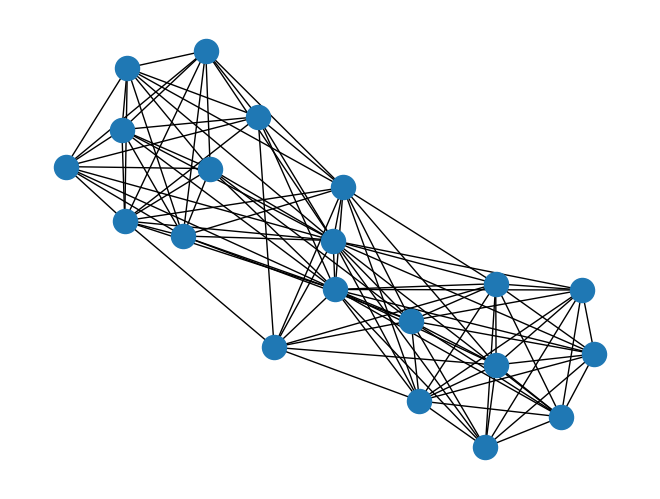

In [4]:
# Visualization code
# G = nx.Graph() 
# g = torch_geometric.utils.to_networkx(ab_wind_dataset_loaded.get(0), to_undirected=True)
# nx.draw(g)

In [9]:
# Simple test GCN
# Modified from source: https://towardsdatascience.com/structure-and-relationships-graph-neural-networks-and-a-pytorch-implementation-c9d83b71c041

class GNNModel(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GNNModel, self).__init__()
        self.conv1 = nn.GATConv(num_node_features, 16)
        self.conv2 = nn.GATConv(16, 8)
        self.fc = nn.Linear(8, 1)  # Outputting a single value per node

    def forward(self, data, target_node_idx=None):
        x, edge_index = data.x, data.edge_index
        x = x.clone()

        # Mask the target node's feature with a value of zero! 
        # Aim is to predict this value from the features of the neighbours
        if target_node_idx is not None:
            x[target_node_idx] = torch.zeros_like(x[target_node_idx])

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.05, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.05, training=self.training)
        x = self.fc(x)

        return x

In [10]:
model = GNNModel(num_node_features=4)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
train_loader = DataLoader(ab_wind_dataset_loaded, batch_size=1, shuffle=True) 

model.train()
for epoch in range(200):
    accumulated_loss = 0 
    optimizer.zero_grad()
    loss = 0  
    for batch_idx, data in enumerate(train_loader):
        output = model(data)  # get predictions with the target node masked
                                    # check the feed forward part of the model
        target = data.y 
        prediction = output
        loss += criterion(prediction, target)
        #Update parameters at the end of each set of batches
        
        loss.backward() 
        optimizer.step()
        optimizer.zero_grad()
        accumulated_loss += loss.item()
        loss = 0

    average_loss = accumulated_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Average Loss: {average_loss}')


Epoch 1, Average Loss: 121.1917209148407
Epoch 2, Average Loss: 71.43662049293518
Epoch 3, Average Loss: 63.252201318740845
Epoch 4, Average Loss: 69.44023673057556
Epoch 5, Average Loss: 62.65817351341248
Epoch 6, Average Loss: 65.49643798828124
Epoch 7, Average Loss: 64.31051937103271
Epoch 8, Average Loss: 64.41086803436279
Epoch 9, Average Loss: 63.77997299194336
Epoch 10, Average Loss: 60.79195214271545
Epoch 11, Average Loss: 60.87314189910889
Epoch 12, Average Loss: 60.97635732650757
Epoch 13, Average Loss: 64.0522143650055
Epoch 14, Average Loss: 61.103221607208255
Epoch 15, Average Loss: 62.1126549243927
Epoch 16, Average Loss: 62.134784355163575
Epoch 17, Average Loss: 62.94621709823608
Epoch 18, Average Loss: 59.68376845359802
Epoch 19, Average Loss: 60.840190782547
Epoch 20, Average Loss: 61.208497533798216
Epoch 21, Average Loss: 60.70029672622681
Epoch 22, Average Loss: 61.35874363899231
Epoch 23, Average Loss: 60.589114112854006
Epoch 24, Average Loss: 64.35620656967163
